# Star tracker error Analysis

We are going to go for a goal of using a 100mm lens exposing for 10 minutes with a DSLR.

Per [Howard's Astronomical Adventures field of view calculator](http://www.howardedin.com/articles/fov.html). For many camera's this gives us 9 to 13 arcseconds per pixel.

With most atmosphere conditions lets assume our goal is to have less than 20 arcseconds/10 minutes.

# Error from Polar Alignment

Error caused by polar alignment can be expressed by this formula. See [Barret, F.A., Determining Polar Axis Alignment Accuracy, (2008)](http://celestialwonders.com/articles/polaralignment/PolarAlignmentAccuracy.pdf)


$ \theta \approx \frac{3.81{\delta}_{err}}{t\cdot\cos\delta} $

$ \theta $  alignment error (arc minutes) <br/>
$ \delta_{err} $ drift (arc seconds)<br/>
$ t $ time of the drift (minutes)<br/>
$ \delta $ declination of target star<br/>



In [2]:
import math
sigma_err = 20.0
t = 10
sigma = 0.0

theta = 3.81*sigma_err/(t*math.cos(sigma))
print "%f'" % (theta,)
print "%f deg" % (theta/60.)

7.620000'
0.127000 deg


We can plot maximum alignment error based on the declination of the object while keeping a dift of 20 arcseconds per 10 minutes.


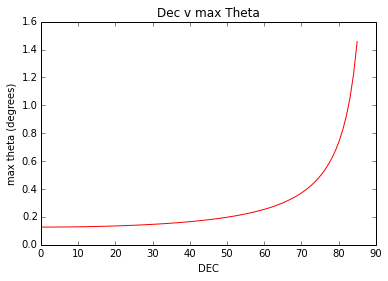

In [12]:
%matplotlib inline
from pylab import *
import math

delta_err = 20.0
t = 10.0
dec = linspace(0.0, 85.0, 90)
theta = (3.81*delta_err/(t*cos(dec*math.pi/180.0)))/60.0
figure()
plot(dec, theta, 'r')
xlabel('DEC')
ylabel('max theta (degrees)')
title('Dec v max Theta')
show()


# Measurement Errors

The purpose of calculating these errors is to see how exact our measurements need to be to not introduce too much error. Below is a diagram with various measurements labeled:

<center><img src="files/tracker_dims.png"></center>

To calculate the errors we will do the following:

$\delta_e = |f(t, r_i, d_s, d_f, C_{threads}, C_{steps}  ) - f(t, r_i \pm \Delta r_i, d_s \pm \Delta d_s, d_f \pm \Delta d_f, C_{threads} \pm \Delta C_{threads}, C_{steps} \pm \Delta C_{steps}) | $

The $ \Delta $ values will be 0 or a value we want to see what the error would be if the value was off by that amount.

$ t $ is time<br/>
$ C_{threads} $ is threads per inch of the rod<br/>
$ C_{steps} $ is steps per rotation of the stepper<br/>


In [13]:
import math
import numpy
from scipy.optimize import fmin

MICROSTEP = 8.0
def rad_to_arcsec(rad):
    return rad*(180.0/(math.pi))*60.0*60.0

def calc_rod_len(r_i, d_s, theta):
    psi = 0.5*math.pi - theta
    r = r_i - d_s * math.tan(math.pi/2.0 - psi)
    d = r * math.sin(theta) / math.sin(psi)
    return d

def calc_theta(t, r_i, d_s, d_f):
    theta_initial = math.atan(d_f/r_i)
    t_sr = t*1.0027379
    theta = theta_initial + 0.25 * math.pi * t_sr / 10800.0
    return theta
    
def calc_steps(theta, r_i, d_s, d_f, c_threads, c_steps):
    theta_initial = math.atan(d_f/r_i)
    d_initial = calc_rod_len(r_i, d_s, theta_initial)

    d = calc_rod_len(r_i, d_s, theta)
    total_steps = MICROSTEP * (d-d_initial) * c_steps * c_threads
    return total_steps

#Returns theta
def inv_calc_steps(total_steps, theta_guess, r_i, d_s, d_f, c_threads, c_steps):
    def ourFunc(theta):
        return abs(total_steps - calc_steps(theta, r_i, d_s, d_f, c_threads, c_steps))
    #TODO: Minimize method
    v=fmin(ourFunc, theta_guess, ftol=0.000001)
    return v[0]
    
iv = {'t': 10.0*60.0, 'r_i': 6.9, 'd_s': 0.262, 'd_f': 1.5, 'c_threads': 20.0, 'c_steps': 200.0}
rounds = [
          ['zero', {'t': 0.0, 'r_i': 0.0, 'd_s': 0.0, 'd_f': 0.0, 'c_threads': 0.0, 'c_steps': 0.0}],
          ['t +/- 0.9', {'t': 0.3, 'r_i': 0.0, 'd_s': 0.0, 'd_f': 0.0, 'c_threads': 0.0, 'c_steps': 0.0}],
          ['r_i +/- 0.1', {'t': 0.0, 'r_i': 0.1, 'd_s': 0.0, 'd_f': 0.0, 'c_threads': 0.0, 'c_steps': 0.0}],
          ['d_s +/- 0.1', {'t': 0.0, 'r_i': 0.0, 'd_s': 0.1, 'd_f': 0.0, 'c_threads': 0.0, 'c_steps': 0.0}],
          ['d_f +/- 0.1', {'t': 0.0, 'r_i': 0.0, 'd_s': 0.0, 'd_f': 0.1, 'c_threads': 0.0, 'c_steps': 0.0}],
          ['c_threads +/- 0.1', {'t': 0.0, 'r_i': 0.0, 'd_s': 0.0, 'd_f': 0.0, 'c_threads': 0.1, 'c_steps': 0.0}],
          ['c_steps +/- 1.0', {'t': 0.0, 'r_i': 0.0, 'd_s': 0.0, 'd_f': 0.0, 'c_threads': 0.0, 'c_steps': 1.0}]
          ]
errors = []
for round in rounds:
    print "Processing "+round[0]
    rv = round[1]
    #correct_steps = calc_steps(calc_theta(iv['t'], iv['r_i'], iv['d_s'], iv['d_f']), iv['r_i'], iv['d_s'], iv['d_f'], iv['c_threads'], iv['c_steps'])
    error_thetas = []
    for m in [1.0, -1.0]:
        error_steps = calc_steps(\
            calc_theta(iv['t']+m*rv['t'], iv['r_i']+m*rv['r_i'], iv['d_s']+m*rv['d_s'], iv['d_f']+m*rv['d_f']),\
            iv['r_i']+m*rv['r_i'], iv['d_s']+m*rv['d_s'], iv['d_f']+m*rv['d_f'], iv['c_threads']+m*rv['c_threads'], \
            iv['c_steps']+m*rv['c_steps'])
        error_theta = inv_calc_steps(error_steps, 0.13, iv['r_i'], iv['d_s'], iv['d_f'], iv['c_threads'], iv['c_steps'])
        error_thetas.append(error_theta)
    correct_theta = calc_theta(iv['t'], iv['r_i'], iv['d_s'], iv['d_f'])
    err = max(abs(numpy.array(error_thetas)-correct_theta))
    errors.append("%s error = %f arcseconds " % (round[0], rad_to_arcsec(err)))

print
print

for err in errors:
    print err
        

Processing zero
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 32
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 32
         Function evaluations: 64
Processing t +/- 0.9
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 37
         Function evaluations: 74
Processing r_i +/- 0.1
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 38
         Function evaluations: 76
Optimization terminated successfully.
         Current function value: 0.000001
         Iterations: 38
         Function evaluations: 76
Processing d_s +/- 0.1
Optimization terminated successfully.
         Current function value: 0.000001
         

# Microcontroller Oscillator Error

The 16Mhz crystal oscilator typically used on microcontroller board such as the Arduino have a 50 or 100 ppm error. Some cheaper arduino compatible boards use reasonators, that could be off by 0.5% or more.

In [14]:
def calc_time_theta(t):
    t_sr = t*1.0027379
    theta = 0.25 * math.pi * t_sr / 10800.0
    return theta

minutes = 10.0
time = 60*minutes


#Crystal

error_ppm = 100.0
clock_hz = 16000000.0

error_hz = (clock_hz/1000000.0)*error_ppm

error_time = time - time*(clock_hz-error_hz)/clock_hz
error_theta = calc_time_theta(time) - calc_time_theta(time-error_time)
print "Over %d minutes:" % (minutes)
print "Crystal error: +/- %fs =  %f\"" % (error_time, rad_to_arcsec(error_theta))

#Resonator
error_ppm = 0.005 * 1e6
error_hz = (clock_hz/1000000.0)*error_ppm

error_time = time - time*(clock_hz-error_hz)/clock_hz
error_theta = calc_time_theta(time) - calc_time_theta(time-error_time)

print "Resonator error: +/- %fs = %f\"" % (error_time, rad_to_arcsec(error_theta))

Over 10 minutes:
Crystal error: +/- 0.060000s =  0.902464"
Resonator error: +/- 3.000000s = 45.123205"


# Calibration

# Power Usage

How much power does the tracker use and how much will certain batteries be able to power it. 

* TODO: Measure power usage
* TODO: Measure usage using different microsteps
* TODO: Measure power usage of just arduino and driver to see if it is worth replacing voltage regulator.

Quick measurement with my stepup, at 12V it showed a initial spike of 500mA. It ran continously at 390mA.

# Test Jig and Feedback

## Time of Flight Distance Measurement

I had the idea of using a Time of Flight light based distance measurement chip to get feedback on the position of the plate. The time of flight sensor I used was accurate to 1mm. This is shown to be not nearly what we need using a 185mm plate.

$$ \arctan(1mm/185.42mm) \approx 0.309^\circ \approx 18.6' \gg 5" $$

In fact the plate we should need would be super long.

$$ \cot(9") \cdot 1mm \approx 22918mm \approx 75 ft $$

## Accelerometer

### Quick example Single-axis tilt calculation

If we were to really use an accelerometer we would use a three axis one. For sake of seeing if this is feasible, lets assume we can mount it so a single axis will work, how much precision would we need?

With $x$ being in a fraction of $g$ recorded by the accelerometer $ \theta = \arcsin(x) $

$$ sin(9") = 0.0000436 $$

The most common accelerometer has a precision of 1mg or 206 arcsecond.

Kionix KX123-1039 claims a typical 16384 counts/g accelerometer. Maybe: 0.000061g or 12 arcsecond?

## Double Artificial Star

In [27]:
Adj = 408.
# 100 px apart 50 px each at 3.92"/px is 196 arcsec
theta = (math.pi/180.0) * (196./(60.*60.))
#0.1 arcseconds
threshold = (math.pi/180.0) * (0.1/(60.*60.))
print threshold


Op = Adj * math.tan(theta)
print Op

theta2 = math.atan(Op/Adj) - math.atan((Op)/(Adj+0.1))
print theta2

4.8481368111e-07
0.387695921199
2.32843480318e-07


# References and similar projects

* Berrangé, Daniel. "Building a Barn Door Mount." F138. 1 Jan. 2014. Web. 3 May 2015. <http://fstop138.berrange.com/2014/01/building-an-barn-door-mount-part-1-arduino-stepper-motor-control/>.
* Wierenga, Theron. "A Barn Door Tracker for AstroPhotography." Nuts & Volts 1 Jan. 2015: 26. Print.
* Barret, F.A. "Determining Polar Axis Alignment Accuracy" 2008 <http://celestialwonders.com/articles/polaralignment/PolarAlignmentAccuracy.pdf>
* ZZJ. "ZZJ's Barn Door Tracker" 10 May 2015. <http://ridetheclown.com/BarnTracker/>
* Joris van Rantwijk. "Arduino clock frequency stability" 18 May 2015. <http://jorisvr.nl/arduino_frequency.html>
* 